#20 News Group
Parsing: remove punctuations, lower case, tokenize, remove stop words, probably limit words<br>
Normalization: for each doc, for all word count freq of word and create hashmap of unique_word(w): freq(w)<br>
Pairwise Similarity: cosine similarity of 2 hashmap (w:freq(w))<br>
<br>
transformation: .tar -> text -> [doc] -> [dict(w:freq(w))]<br>
<br>
Eg:<br>
text = "Hello mat. How are you? \n Hi Mat! How are you today." -> {hello: 1,mat:1,how:1,are:1,you:1} {hi:1, mat:1, how:1, are:1, you:1, today:1}<br>
cos_sim = 1+1+1+1 / sqrt(5)*sqrt(6) = 0.73<br>

#1. Parsing

In [ ]:
!pip install scipy

In [ ]:
from sklearn.datasets import fetch_20newsgroups
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from collections import Counter
import math
from google.colab import drive
drive.mount('/content/drive')
from sklearn.datasets import load_files
import pickle
import numpy as np
import matplotlib.pyplot as plt
nltk.download('wordnet')
from scipy.sparse import csr_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
docs = fetch_20newsgroups(subset='all')

In [ ]:
docs.keys()

dict_keys(['data', 'filenames', 'target_names', 'target', 'DESCR'])

In [ ]:
len(docs.data)

18846

In [ ]:
labels = docs.target

In [ ]:
def preprocess_text(text):
  text = re.sub(r'[^a-zA-Z0-9 \n]', '', text)
  text = re.sub(r'\n+', ' ', text)
  text = text.lower()
  tokens = word_tokenize(text)
  stop_words = set(stopwords.words('english'))
  tokens = [word for word in tokens if word not in stop_words]
  dict_tokens = dict(Counter(tokens))
  return dict_tokens

In [ ]:
processed_docs = []
for i in range(len(docs.data)):
  processed_docs.append(preprocess_text(docs.data[i]))

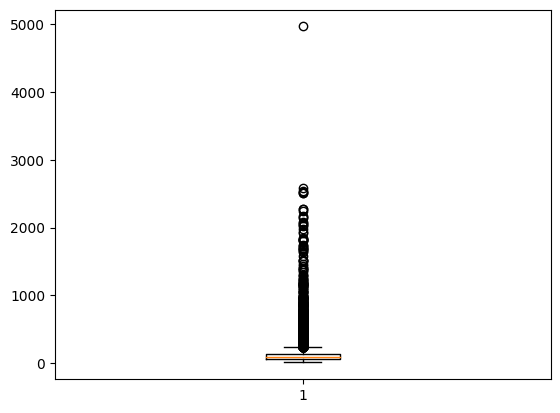

In [ ]:
# box plot of number of tokens in processed_docs
plt.boxplot([len(x) for x in processed_docs])
plt.show()

In [ ]:
# mean, median of number of tokens in processed_docs
print(np.mean([len(x) for x in processed_docs]))
print(np.median([len(x) for x in processed_docs]))

115.51464501751035
84.0


In [ ]:
# average length of all tokens in processed_docs
token_length_sum = 0
unique_tokens = set()
for i in range(len(processed_docs)):
  for word in processed_docs[i]:
    token_length_sum += len(word)
    unique_tokens.add(word)
print(token_length_sum/len(unique_tokens))

77.83682766907866


In [ ]:
# median length of all tokens in processed_docs
token_lengths = []
unique_tokens = list(unique_tokens)


m2gez8qqwlp4g78qux7lnqokyvcusfsbee4


In [ ]:
from nltk.corpus import wordnet

def is_valid_word(word):
    return bool(wordnet.synsets(word))


Valid words: ['collimated', 'territory']
Invalid words: ['6042559937', 'm3grga86a86a86a86a86a86a86a86rgrgrfb8fb4q', 'buechele']


In [ ]:
filtered_unique_tokens = []
for word in unique_tokens:
  if(is_valid_word(word)):
    filtered_unique_tokens.append(word)

In [ ]:
print(len(filtered_unique_tokens),len(unique_tokens))

40791 191405


In [ ]:
# IDF measures how important a term is across the entire corpus. Terms that appear in many documents have a lower IDF.
# Inverse Doc Freq = N/nt (N=Number of docs=18846, nt=number of documents that contain the term t)
# Absolute word count (AWC) = Number of times a term appeared in corpus
# Importance of term in entire corpus = IDF * AWC
# Out of arnd 40k unique tokens I will select 10k tokens with highest importance

In [ ]:
imp_filtered_tokens = {}

for token in filtered_unique_tokens:
  doc_count = 0
  abs_word_count = 0
  for i in range(len(processed_docs)):
    if(token in processed_docs[i]):
      doc_count += 1
      abs_word_count += processed_docs[i][token]
  idf = len(processed_docs)/doc_count
  imp_filtered_tokens[token] = idf*abs_word_count

In [ ]:
most_important_10k_tokens = sorted(imp_filtered_tokens, key=imp_filtered_tokens.get, reverse=True)[:15000]

In [ ]:
most_important_10k_tokens.sort()

In [ ]:
filename = '/content/drive/MyDrive/USML/HW1/Prob_3/most_important_10k_tokens_sorted.pkl'

with open(filename, 'wb') as file:
    pickle.dump(processed_docs, file)


In [ ]:
dataset = np.zeros((18846, 15000))

In [ ]:
for i in range(len(processed_docs)):
  for j in range(len(most_important_10k_tokens)):
    if(most_important_10k_tokens[j] in processed_docs[i]):
      dataset[i][j] = 1

In [ ]:
zero_count = np.count_nonzero(dataset == 0)

# Calculate the total number of elements
total_elements = dataset.size

# Calculate sparsity of the matrix
sparsity = zero_count / total_elements

print(f"Number of zeros: {zero_count}")
print(f"Total elements: {total_elements}")
print(f"Sparsity: {sparsity:.4f}")  # Formatted to 4 decimal places

Number of zeros: 281371405
Total elements: 282690000
Sparsity: 0.9953


In [ ]:
dataset = dataset.astype(np.uint8)

In [ ]:
filename = '/content/drive/MyDrive/USML/HW1/Prob_3/dataset.pkl'

with open(filename, 'wb') as file:
    pickle.dump(processed_docs, file)


In [ ]:
# Cosign Sim

In [ ]:
sparse_text_flat = csr_matrix(dataset)

In [ ]:
dot_product = sparse_text_flat.dot(sparse_text_flat.T)

In [ ]:
mag_arr = np.sum(dataset, axis=1)

In [ ]:
non_zero_values = dot_product.data

In [ ]:
non_zero_values.shape

(302681679,)

In [ ]:
dot_product.shape

(18846, 18846)

## PROBLEM 4: MNIST, 20 NG : Train and test KNN classification (supervised)
Your goal in this problem is to write your own K-nearest neighbor (KNN) classifier.

For each of the two datasets, now in matrix format and with pairwise similarity computed, train and test a KNN classifier. You are required to implement KNN classification model yourself, though you may use support libraries / data-structures for the neighbor searching.

You should partition the datasets into (say) an 80/10/10 training/testing/validation sets. Note that the actual "training" here consists of simply identifying nearest neighbors---unlike other common classifiers, there is no iterative or gradient-based procedure.

Report both training performance and testing performance. If using Python, you are encouraged (but not required) to write a scikit-learn compatible *estimator* class supporting a common API interface, e.g. *.fit(), *.predict(), *.transform(), etc. See https://scikit-learn.org/stable/developers/develop.html for more details.

In [ ]:
# train = 0 - 15,076 ; val = 15,077 - 16,960 ; test = 16,961- 18,845

In [ ]:
def cosine_similarity(idx1, idx2):
  row_at_idx = dot_product.getrow(idx1).toarray()
  dot_prod = row_at_idx[0][idx2]
  mag_1 = np.sqrt(mag_arr[idx1])
  mag_2 = np.sqrt(mag_arr[idx2])
  return dot_prod / (mag_1 * mag_2)




In [ ]:
def evaluate(idx, k=10):
  heap = []
  for i in range(100): ###
    curr_cos_sim = cosine_similarity(idx, i)
    if len(heap) == 0:
      heap.append([curr_cos_sim,i])
    else:
      if (heap[0][0]<curr_cos_sim):
        heap.insert(0, [curr_cos_sim,i])
      else:
        heap.append([curr_cos_sim,i])
        heap.sort(key=lambda x: x[0],reverse=True)
      if(len(heap)>k):
        heap.pop(-1)

  # reporting most frequent label
  d = {}
  for i in range(k):
    if labels[heap[i][1]] in d:
      d[labels[heap[i][1]]] += 1
    else:
      d[labels[heap[i][1]]] = 1
  return max(d, key=d.get)


In [ ]:
# Evaluating train
correct = 0
for i in range(100): ####
  if(evaluate(i) == labels[i]):
    correct += 1
print(f'Training Accuracy: {(correct/100)*100}') ####

Training Accuracy: 69.0


In [ ]:
# Evaluating Validation
correct = 0
for i in range(15077,15177): ####
  if(evaluate(i) == labels[i]):
    correct += 1
print(f'Validation Accuracy: {(correct/100)*100}') ####

Validation Accuracy: 30.0


In [ ]:
# Evaluating Test
correct = 0
for i in range(16961,17061): ####
  if(evaluate(i) == labels[i]):
    correct += 1
print(f'Test Accuracy: {(correct/100)*100}') ####

Test Accuracy: 26.0


In [ ]:
# euclid Distance

In [ ]:
def optimized_euclid_dist(x, y):
  result = x ^ y
  dist = np.sum(result)
  del result
  return dist.astype(np.uint16)


In [ ]:
size = 177576435
data = np.zeros(size, dtype=np.uint32)
row = np.zeros(size, dtype=np.uint32)
col = np.zeros(size, dtype=np.uint32)

In [ ]:
subset_sz = 18846
row_sz = subset_sz * (subset_sz - 1) // 2

subset = dataset[0:subset_sz] # For testing
subset_row = row[0:row_sz]
subset_col = col[0:row_sz]
subset_data = data[0:row_sz]

print("Total size in bytes:", subset_data.nbytes+subset_row.nbytes+subset_col.nbytes)

Total size in bytes: 2130917220


In [ ]:
# Just running through the loop without any processing involved takes 22.5 min occupying 30GBs of space
data_idx = 0

for i in range(subset_sz):
  for j in range(i + 1, subset_sz):
    # subset_row[data_idx] = i
    # subset_col[data_idx] = j
    subset_data[data_idx] = optimized_euclid_dist(subset[i],subset[j])
    data_idx += 1


## PROBLEM 4: MNIST, 20 NG : Train and test KNN classification (supervised)
Your goal in this problem is to write your own K-nearest neighbor (KNN) classifier.

For each of the two datasets, now in matrix format and with pairwise similarity computed, train and test a KNN classifier. You are required to implement KNN classification model yourself, though you may use support libraries / data-structures for the neighbor searching.

You should partition the datasets into (say) an 80/10/10 training/testing/validation sets. Note that the actual "training" here consists of simply identifying nearest neighbors---unlike other common classifiers, there is no iterative or gradient-based procedure.

Report both training performance and testing performance. If using Python, you are encouraged (but not required) to write a scikit-learn compatible *estimator* class supporting a common API interface, e.g. *.fit(), *.predict(), *.transform(), etc. See https://scikit-learn.org/stable/developers/develop.html for more details.

In [ ]:
def map_matrix_to_flat_idx(r,c):
  return int((r/2)*(140000+1-r) + c)

In [153]:
def eval_for_test_and_val(idx, k=10):
  heap = []
  for i in range(100): ###
    arr_idx = map_matrix_to_flat_idx(i,idx)
    curr_dist = subset_data[arr_idx]
    if len(heap) == 0:
      heap.append([curr_dist,i])
    else:
      if (heap[0][0]>curr_dist):
        heap.insert(0, [curr_dist,i])
      else:
        heap.append([curr_dist,i])
        heap.sort(key=lambda x: x[0])
      if(len(heap)>k):
        heap.pop(-1)

  # reporting most frequent label
  d = {}
  for i in range(k):
    if labels[heap[i][1]] in d:
      d[labels[heap[i][1]]] += 1
    else:
      d[labels[heap[i][1]]] = 1
  return max(d, key=d.get)


In [154]:
def eval_for_train(idx, k=10):
  heap = []
  for i in range(idx+1,100): ###
    arr_idx = map_matrix_to_flat_idx(idx,i)
    #print(arr_idx)
    curr_dist = subset_data[arr_idx]
    if len(heap) == 0:
      heap.append([curr_dist,i])
    else:
      if (heap[0][0]>curr_dist):
        heap.insert(0, [curr_dist,i])
      else:
        heap.append([curr_dist,i])
        heap.sort(key=lambda x: x[0])
      if(len(heap)>k):
        heap.pop(-1)

  for i in range(idx): ###
    arr_idx = map_matrix_to_flat_idx(i,idx)
    curr_dist = subset_data[arr_idx]
    if len(heap) == 0:
      heap.append([curr_dist,i])
    else:
      if (heap[0][0]>curr_dist):
        heap.insert(0, [curr_dist,i])
      else:
        heap.append([curr_dist,i])
        heap.sort(key=lambda x: x[0])
      if(len(heap)>k):
        heap.pop(-1)

  # reporting most frequent label
  d = {}
  for i in range(k):
    if labels[heap[i][1]] in d:
      d[labels[heap[i][1]]] += 1
    else:
      d[labels[heap[i][1]]] = 1
  return max(d, key=d.get)


In [155]:
# Evaluating train
correct = 0
for i in range(100): ####
  if(eval_for_train(i) == labels[i]):
    correct += 1
print(f'Training Accuracy: {(correct/100)*100}') ####

Training Accuracy: 7.000000000000001


In [157]:
# Evaluating Validation
correct = 0
for i in range(15077,15177): ####
  if(eval_for_test_and_val(i) == labels[i]):
    correct += 1
print(f'Validation Accuracy: {(correct/100)*100}') ####

Validation Accuracy: 3.0


In [158]:
# Evaluating Validation
correct = 0
for i in range(16961,17061): ####
  if(eval_for_test_and_val(i) == labels[i]):
    correct += 1
print(f'Validation Accuracy: {(correct/100)*100}')

Validation Accuracy: 8.0
